In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import re
%matplotlib inline 

In [2]:
model_name = "subtract_lepphi_0_2pi"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  100000 

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if False:
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi1_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if False:
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi1_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)

total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)

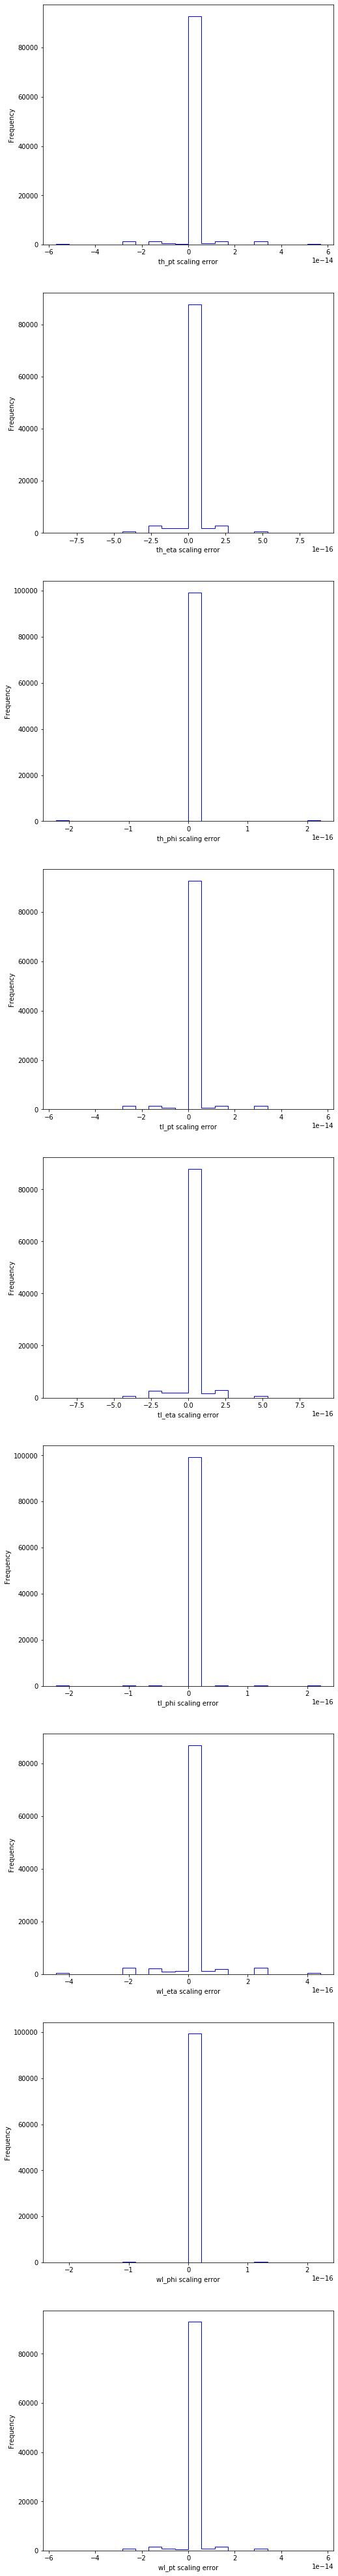

In [8]:
# Test inverse scaling

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 36) (80000, 9)
(20000, 36) (20000, 9)


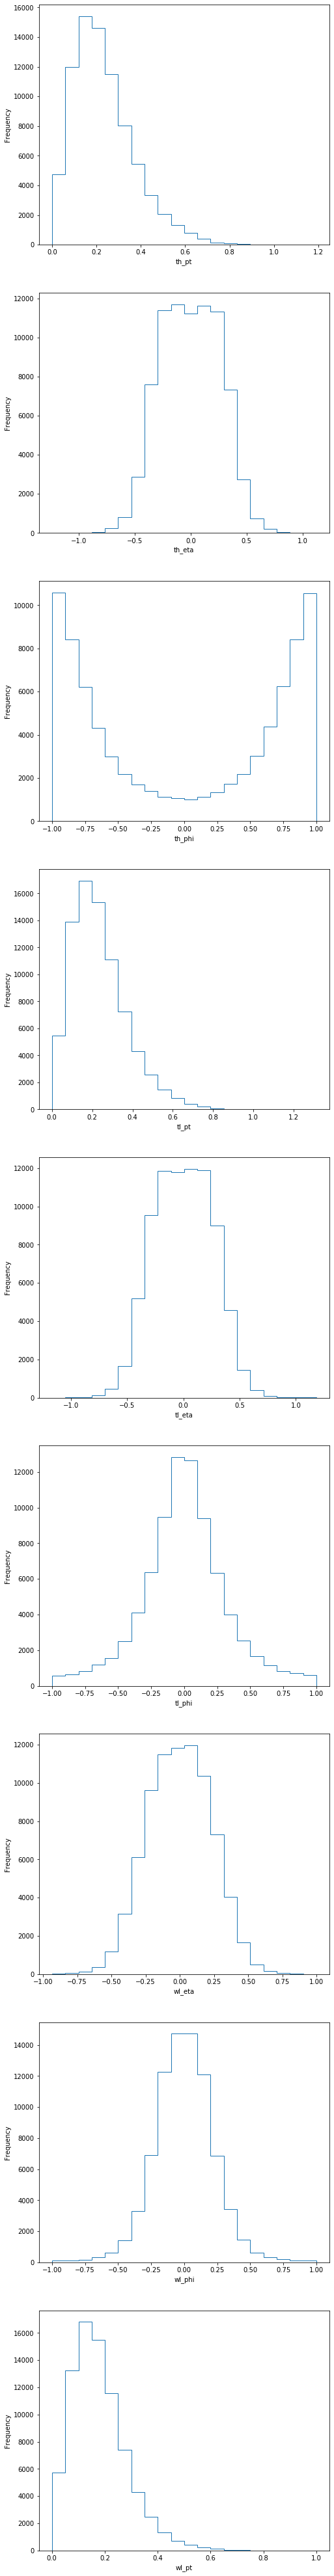

In [11]:
# Histograms of output variables 
show = True

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(train_output[:,i], 20, histtype='step')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')

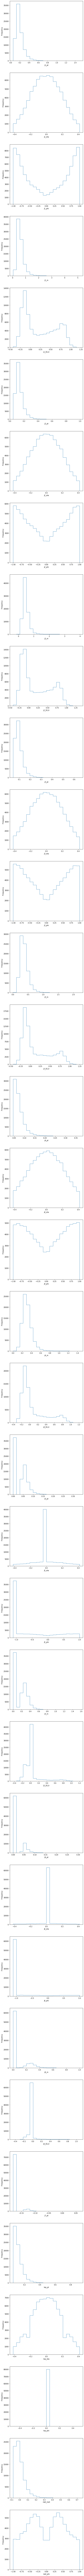

In [12]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [13]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [15]:
# Fit model

Epochs= 4096

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1318 - mse: 0.1251 - val_loss: 0.1304 - val_mse: 0.1236
Epoch 2/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1301 - mse: 0.1233 - val_loss: 0.1287 - val_mse: 0.1219
Epoch 3/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1284 - mse: 0.1216 - val_loss: 0.1270 - val_mse: 0.1202
Epoch 4/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1267 - mse: 0.1199 - val_loss: 0.1253 - val_mse: 0.1186
Epoch 5/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1250 - mse: 0.1183 - val_loss: 0.1236 - val_mse: 0.1169
Epoch 6/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1233 - mse: 0.1166 - val_loss: 0.1220 - val_mse: 0.1153
Epoch 7/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1216 - mse: 0.1149 - val_loss: 0.1203 - val_mse: 0.1136
Epoch 8/4096
125/125 [==============================] - 1s 5ms

Epoch 62/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0882 - mse: 0.0819 - val_loss: 0.0881 - val_mse: 0.0818
Epoch 63/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0880 - mse: 0.0817 - val_loss: 0.0879 - val_mse: 0.0816
Epoch 64/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0879 - mse: 0.0816 - val_loss: 0.0878 - val_mse: 0.0815
Epoch 65/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0877 - mse: 0.0814 - val_loss: 0.0876 - val_mse: 0.0813
Epoch 66/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0876 - mse: 0.0813 - val_loss: 0.0875 - val_mse: 0.0812
Epoch 67/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0874 - mse: 0.0811 - val_loss: 0.0873 - val_mse: 0.0811
Epoch 68/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0873 - mse: 0.0810 - val_loss: 0.0872 - val_mse: 0.0809
Epoch 69/4096
125/125 [==============================] 

125/125 [==============================] - 1s 5ms/step - loss: 0.0818 - mse: 0.0758 - val_loss: 0.0820 - val_mse: 0.0760
Epoch 123/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0818 - mse: 0.0758 - val_loss: 0.0820 - val_mse: 0.0760
Epoch 124/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0818 - mse: 0.0757 - val_loss: 0.0820 - val_mse: 0.0760
Epoch 125/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0817 - mse: 0.0757 - val_loss: 0.0819 - val_mse: 0.0759
Epoch 126/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0817 - mse: 0.0757 - val_loss: 0.0819 - val_mse: 0.0759
Epoch 127/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0816 - mse: 0.0756 - val_loss: 0.0818 - val_mse: 0.0759
Epoch 128/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0816 - mse: 0.0756 - val_loss: 0.0818 - val_mse: 0.0758
Epoch 129/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0797 - mse: 0.0740 - val_loss: 0.0802 - val_mse: 0.0744
Epoch 183/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0797 - mse: 0.0740 - val_loss: 0.0802 - val_mse: 0.0744
Epoch 184/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0797 - mse: 0.0739 - val_loss: 0.0801 - val_mse: 0.0744
Epoch 185/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0797 - mse: 0.0739 - val_loss: 0.0801 - val_mse: 0.0744
Epoch 186/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0796 - mse: 0.0739 - val_loss: 0.0801 - val_mse: 0.0743
Epoch 187/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0796 - mse: 0.0739 - val_loss: 0.0801 - val_mse: 0.0743
Epoch 188/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0796 - mse: 0.0738 - val_loss: 0.0800 - val_mse: 0.0743
Epoch 189/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0782 - mse: 0.0726 - val_loss: 0.0788 - val_mse: 0.0733
Epoch 243/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0782 - mse: 0.0726 - val_loss: 0.0788 - val_mse: 0.0733
Epoch 244/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0781 - mse: 0.0726 - val_loss: 0.0788 - val_mse: 0.0733
Epoch 245/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0781 - mse: 0.0726 - val_loss: 0.0788 - val_mse: 0.0732
Epoch 246/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0781 - mse: 0.0725 - val_loss: 0.0787 - val_mse: 0.0732
Epoch 247/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0781 - mse: 0.0725 - val_loss: 0.0787 - val_mse: 0.0732
Epoch 248/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0780 - mse: 0.0725 - val_loss: 0.0787 - val_mse: 0.0732
Epoch 249/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0768 - mse: 0.0714 - val_loss: 0.0777 - val_mse: 0.0723
Epoch 303/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0768 - mse: 0.0714 - val_loss: 0.0777 - val_mse: 0.0723
Epoch 304/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0768 - mse: 0.0714 - val_loss: 0.0777 - val_mse: 0.0723
Epoch 305/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0767 - mse: 0.0714 - val_loss: 0.0776 - val_mse: 0.0723
Epoch 306/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0767 - mse: 0.0714 - val_loss: 0.0776 - val_mse: 0.0723
Epoch 307/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0767 - mse: 0.0713 - val_loss: 0.0776 - val_mse: 0.0723
Epoch 308/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0767 - mse: 0.0713 - val_loss: 0.0776 - val_mse: 0.0722
Epoch 309/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0756 - mse: 0.0704 - val_loss: 0.0767 - val_mse: 0.0715
Epoch 363/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0756 - mse: 0.0703 - val_loss: 0.0767 - val_mse: 0.0715
Epoch 364/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0755 - mse: 0.0703 - val_loss: 0.0767 - val_mse: 0.0715
Epoch 365/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0755 - mse: 0.0703 - val_loss: 0.0767 - val_mse: 0.0715
Epoch 366/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0755 - mse: 0.0703 - val_loss: 0.0767 - val_mse: 0.0714
Epoch 367/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0755 - mse: 0.0703 - val_loss: 0.0767 - val_mse: 0.0714
Epoch 368/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0755 - mse: 0.0703 - val_loss: 0.0766 - val_mse: 0.0714
Epoch 369/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0745 - mse: 0.0694 - val_loss: 0.0759 - val_mse: 0.0708
Epoch 423/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0745 - mse: 0.0694 - val_loss: 0.0759 - val_mse: 0.0708
Epoch 424/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0745 - mse: 0.0694 - val_loss: 0.0759 - val_mse: 0.0708
Epoch 425/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0745 - mse: 0.0693 - val_loss: 0.0759 - val_mse: 0.0708
Epoch 426/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0744 - mse: 0.0693 - val_loss: 0.0759 - val_mse: 0.0708
Epoch 427/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0744 - mse: 0.0693 - val_loss: 0.0759 - val_mse: 0.0708
Epoch 428/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0744 - mse: 0.0693 - val_loss: 0.0758 - val_mse: 0.0707
Epoch 429/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0736 - mse: 0.0685 - val_loss: 0.0753 - val_mse: 0.0703
Epoch 483/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0735 - mse: 0.0685 - val_loss: 0.0753 - val_mse: 0.0703
Epoch 484/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0735 - mse: 0.0685 - val_loss: 0.0753 - val_mse: 0.0702
Epoch 485/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0735 - mse: 0.0685 - val_loss: 0.0752 - val_mse: 0.0702
Epoch 486/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0735 - mse: 0.0685 - val_loss: 0.0752 - val_mse: 0.0702
Epoch 487/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0735 - mse: 0.0685 - val_loss: 0.0752 - val_mse: 0.0702
Epoch 488/4096
125/125 [==============================] - 1s 4ms/step - loss: 0.0735 - mse: 0.0685 - val_loss: 0.0752 - val_mse: 0.0702
Epoch 489/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0727 - mse: 0.0678 - val_loss: 0.0748 - val_mse: 0.0698
Epoch 543/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0727 - mse: 0.0678 - val_loss: 0.0747 - val_mse: 0.0698
Epoch 544/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0727 - mse: 0.0678 - val_loss: 0.0747 - val_mse: 0.0698
Epoch 545/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0727 - mse: 0.0678 - val_loss: 0.0747 - val_mse: 0.0698
Epoch 546/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0727 - mse: 0.0677 - val_loss: 0.0747 - val_mse: 0.0698
Epoch 547/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0727 - mse: 0.0677 - val_loss: 0.0747 - val_mse: 0.0698
Epoch 548/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0726 - mse: 0.0677 - val_loss: 0.0747 - val_mse: 0.0698
Epoch 549/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0720 - mse: 0.0671 - val_loss: 0.0743 - val_mse: 0.0695
Epoch 603/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0720 - mse: 0.0671 - val_loss: 0.0743 - val_mse: 0.0695
Epoch 604/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0719 - mse: 0.0671 - val_loss: 0.0743 - val_mse: 0.0695
Epoch 605/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0719 - mse: 0.0671 - val_loss: 0.0743 - val_mse: 0.0695
Epoch 606/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0719 - mse: 0.0671 - val_loss: 0.0743 - val_mse: 0.0694
Epoch 607/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0719 - mse: 0.0671 - val_loss: 0.0743 - val_mse: 0.0694
Epoch 608/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0719 - mse: 0.0671 - val_loss: 0.0743 - val_mse: 0.0694
Epoch 609/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0713 - mse: 0.0665 - val_loss: 0.0740 - val_mse: 0.0692
Epoch 663/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0713 - mse: 0.0665 - val_loss: 0.0739 - val_mse: 0.0692
Epoch 664/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0713 - mse: 0.0665 - val_loss: 0.0739 - val_mse: 0.0691
Epoch 665/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0713 - mse: 0.0665 - val_loss: 0.0739 - val_mse: 0.0691
Epoch 666/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0712 - mse: 0.0664 - val_loss: 0.0739 - val_mse: 0.0691
Epoch 667/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0712 - mse: 0.0664 - val_loss: 0.0739 - val_mse: 0.0691
Epoch 668/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0712 - mse: 0.0664 - val_loss: 0.0739 - val_mse: 0.0691
Epoch 669/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0706 - mse: 0.0659 - val_loss: 0.0736 - val_mse: 0.0689
Epoch 723/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0706 - mse: 0.0659 - val_loss: 0.0736 - val_mse: 0.0689
Epoch 724/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0706 - mse: 0.0659 - val_loss: 0.0736 - val_mse: 0.0689
Epoch 725/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0706 - mse: 0.0659 - val_loss: 0.0736 - val_mse: 0.0689
Epoch 726/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0706 - mse: 0.0659 - val_loss: 0.0736 - val_mse: 0.0689
Epoch 727/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0706 - mse: 0.0658 - val_loss: 0.0736 - val_mse: 0.0689
Epoch 728/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0706 - mse: 0.0658 - val_loss: 0.0736 - val_mse: 0.0689
Epoch 729/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0700 - mse: 0.0653 - val_loss: 0.0733 - val_mse: 0.0686
Epoch 783/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0700 - mse: 0.0653 - val_loss: 0.0733 - val_mse: 0.0686
Epoch 784/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0700 - mse: 0.0653 - val_loss: 0.0733 - val_mse: 0.0686
Epoch 785/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0700 - mse: 0.0653 - val_loss: 0.0733 - val_mse: 0.0686
Epoch 786/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0700 - mse: 0.0653 - val_loss: 0.0733 - val_mse: 0.0686
Epoch 787/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0700 - mse: 0.0653 - val_loss: 0.0733 - val_mse: 0.0686
Epoch 788/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0700 - mse: 0.0653 - val_loss: 0.0733 - val_mse: 0.0686
Epoch 789/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0694 - mse: 0.0648 - val_loss: 0.0731 - val_mse: 0.0684
Epoch 843/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0694 - mse: 0.0648 - val_loss: 0.0731 - val_mse: 0.0684
Epoch 844/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0694 - mse: 0.0648 - val_loss: 0.0731 - val_mse: 0.0684
Epoch 845/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0694 - mse: 0.0647 - val_loss: 0.0730 - val_mse: 0.0684
Epoch 846/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0694 - mse: 0.0647 - val_loss: 0.0730 - val_mse: 0.0684
Epoch 847/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0694 - mse: 0.0647 - val_loss: 0.0730 - val_mse: 0.0684
Epoch 848/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0694 - mse: 0.0647 - val_loss: 0.0730 - val_mse: 0.0684
Epoch 849/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0688 - mse: 0.0642 - val_loss: 0.0728 - val_mse: 0.0682
Epoch 903/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0688 - mse: 0.0642 - val_loss: 0.0728 - val_mse: 0.0682
Epoch 904/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0688 - mse: 0.0642 - val_loss: 0.0728 - val_mse: 0.0682
Epoch 905/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0688 - mse: 0.0642 - val_loss: 0.0728 - val_mse: 0.0682
Epoch 906/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0688 - mse: 0.0642 - val_loss: 0.0728 - val_mse: 0.0682
Epoch 907/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0688 - mse: 0.0642 - val_loss: 0.0728 - val_mse: 0.0682
Epoch 908/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0688 - mse: 0.0642 - val_loss: 0.0728 - val_mse: 0.0682
Epoch 909/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0683 - mse: 0.0637 - val_loss: 0.0726 - val_mse: 0.0680
Epoch 963/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0683 - mse: 0.0637 - val_loss: 0.0726 - val_mse: 0.0680
Epoch 964/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0683 - mse: 0.0637 - val_loss: 0.0726 - val_mse: 0.0680
Epoch 965/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0683 - mse: 0.0637 - val_loss: 0.0726 - val_mse: 0.0680
Epoch 966/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0683 - mse: 0.0637 - val_loss: 0.0726 - val_mse: 0.0680
Epoch 967/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0682 - mse: 0.0637 - val_loss: 0.0726 - val_mse: 0.0680
Epoch 968/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0682 - mse: 0.0637 - val_loss: 0.0726 - val_mse: 0.0680
Epoch 969/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0677 - mse: 0.0632 - val_loss: 0.0724 - val_mse: 0.0679
Epoch 1023/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0677 - mse: 0.0632 - val_loss: 0.0724 - val_mse: 0.0679
Epoch 1024/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0677 - mse: 0.0632 - val_loss: 0.0724 - val_mse: 0.0679
Epoch 1025/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0677 - mse: 0.0632 - val_loss: 0.0724 - val_mse: 0.0679
Epoch 1026/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0677 - mse: 0.0632 - val_loss: 0.0724 - val_mse: 0.0679
Epoch 1027/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0677 - mse: 0.0632 - val_loss: 0.0724 - val_mse: 0.0679
Epoch 1028/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0677 - mse: 0.0632 - val_loss: 0.0724 - val_mse: 0.0679
Epoch 1029/4096
125/125 [==============================] 

Epoch 1082/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0672 - mse: 0.0627 - val_loss: 0.0723 - val_mse: 0.0678
Epoch 1083/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0672 - mse: 0.0627 - val_loss: 0.0723 - val_mse: 0.0678
Epoch 1084/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0672 - mse: 0.0627 - val_loss: 0.0723 - val_mse: 0.0678
Epoch 1085/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0672 - mse: 0.0627 - val_loss: 0.0723 - val_mse: 0.0677
Epoch 1086/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0672 - mse: 0.0627 - val_loss: 0.0723 - val_mse: 0.0677
Epoch 1087/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0672 - mse: 0.0627 - val_loss: 0.0723 - val_mse: 0.0677
Epoch 1088/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0672 - mse: 0.0627 - val_loss: 0.0723 - val_mse: 0.0677
Epoch 1089/4096
125/125 [================

Epoch 1142/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0667 - mse: 0.0622 - val_loss: 0.0721 - val_mse: 0.0677
Epoch 1143/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0667 - mse: 0.0622 - val_loss: 0.0721 - val_mse: 0.0676
Epoch 1144/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0667 - mse: 0.0622 - val_loss: 0.0721 - val_mse: 0.0676
Epoch 1145/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0667 - mse: 0.0622 - val_loss: 0.0721 - val_mse: 0.0676
Epoch 1146/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0667 - mse: 0.0622 - val_loss: 0.0721 - val_mse: 0.0676
Epoch 1147/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0667 - mse: 0.0622 - val_loss: 0.0721 - val_mse: 0.0676
Epoch 1148/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0667 - mse: 0.0622 - val_loss: 0.0721 - val_mse: 0.0676
Epoch 1149/4096
125/125 [================

Epoch 1202/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0662 - mse: 0.0618 - val_loss: 0.0720 - val_mse: 0.0676
Epoch 1203/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0662 - mse: 0.0618 - val_loss: 0.0720 - val_mse: 0.0676
Epoch 1204/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0662 - mse: 0.0617 - val_loss: 0.0720 - val_mse: 0.0676
Epoch 1205/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0662 - mse: 0.0617 - val_loss: 0.0720 - val_mse: 0.0676
Epoch 1206/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0662 - mse: 0.0617 - val_loss: 0.0720 - val_mse: 0.0676
Epoch 1207/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0662 - mse: 0.0617 - val_loss: 0.0720 - val_mse: 0.0676
Epoch 1208/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0662 - mse: 0.0617 - val_loss: 0.0720 - val_mse: 0.0676
Epoch 1209/4096
125/125 [================

Epoch 1262/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0657 - mse: 0.0613 - val_loss: 0.0719 - val_mse: 0.0675
Epoch 1263/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0657 - mse: 0.0613 - val_loss: 0.0719 - val_mse: 0.0675
Epoch 1264/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0657 - mse: 0.0613 - val_loss: 0.0719 - val_mse: 0.0675
Epoch 1265/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0657 - mse: 0.0613 - val_loss: 0.0719 - val_mse: 0.0675
Epoch 1266/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0657 - mse: 0.0613 - val_loss: 0.0719 - val_mse: 0.0675
Epoch 1267/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0657 - mse: 0.0613 - val_loss: 0.0719 - val_mse: 0.0675
Epoch 1268/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0657 - mse: 0.0613 - val_loss: 0.0719 - val_mse: 0.0675
Epoch 1269/4096
125/125 [================

Epoch 1322/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0653 - mse: 0.0609 - val_loss: 0.0718 - val_mse: 0.0674
Epoch 1323/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0653 - mse: 0.0609 - val_loss: 0.0718 - val_mse: 0.0674
Epoch 1324/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0653 - mse: 0.0608 - val_loss: 0.0718 - val_mse: 0.0674
Epoch 1325/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0652 - mse: 0.0608 - val_loss: 0.0718 - val_mse: 0.0674
Epoch 1326/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0652 - mse: 0.0608 - val_loss: 0.0718 - val_mse: 0.0674
Epoch 1327/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0652 - mse: 0.0608 - val_loss: 0.0718 - val_mse: 0.0674
Epoch 1328/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0652 - mse: 0.0608 - val_loss: 0.0718 - val_mse: 0.0674
Epoch 1329/4096
125/125 [================

125/125 [==============================] - 1s 5ms/step - loss: 0.0648 - mse: 0.0604 - val_loss: 0.0717 - val_mse: 0.0674
Epoch 1382/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0648 - mse: 0.0604 - val_loss: 0.0717 - val_mse: 0.0674
Epoch 1383/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0648 - mse: 0.0604 - val_loss: 0.0717 - val_mse: 0.0674
Epoch 1384/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0648 - mse: 0.0604 - val_loss: 0.0717 - val_mse: 0.0674
Epoch 1385/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0648 - mse: 0.0604 - val_loss: 0.0717 - val_mse: 0.0674
Epoch 1386/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0648 - mse: 0.0604 - val_loss: 0.0717 - val_mse: 0.0674
Epoch 1387/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0648 - mse: 0.0604 - val_loss: 0.0717 - val_mse: 0.0674
Epoch 1388/4096
125/125 [==============================] 

Epoch 1441/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0644 - mse: 0.0600 - val_loss: 0.0717 - val_mse: 0.0673
Epoch 1442/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0644 - mse: 0.0600 - val_loss: 0.0717 - val_mse: 0.0673
Epoch 1443/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0644 - mse: 0.0600 - val_loss: 0.0717 - val_mse: 0.0673
Epoch 1444/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0643 - mse: 0.0600 - val_loss: 0.0717 - val_mse: 0.0673
Epoch 1445/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0643 - mse: 0.0600 - val_loss: 0.0717 - val_mse: 0.0673
Epoch 1446/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0643 - mse: 0.0600 - val_loss: 0.0717 - val_mse: 0.0673
Epoch 1447/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0643 - mse: 0.0600 - val_loss: 0.0717 - val_mse: 0.0673
Epoch 1448/4096
125/125 [================

Epoch 1501/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0639 - mse: 0.0596 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1502/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0639 - mse: 0.0596 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1503/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0639 - mse: 0.0596 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1504/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0639 - mse: 0.0596 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1505/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0639 - mse: 0.0595 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1506/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0639 - mse: 0.0595 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1507/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0639 - mse: 0.0595 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1508/4096
125/125 [================

Epoch 1561/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0635 - mse: 0.0592 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1562/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0635 - mse: 0.0592 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1563/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0635 - mse: 0.0591 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1564/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0635 - mse: 0.0591 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1565/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0635 - mse: 0.0591 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1566/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0635 - mse: 0.0591 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1567/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0634 - mse: 0.0591 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1568/4096
125/125 [================

Epoch 1621/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0631 - mse: 0.0588 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1622/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0631 - mse: 0.0587 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1623/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0631 - mse: 0.0587 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1624/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0630 - mse: 0.0587 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1625/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0630 - mse: 0.0587 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1626/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0630 - mse: 0.0587 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1627/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0630 - mse: 0.0587 - val_loss: 0.0716 - val_mse: 0.0673
Epoch 1628/4096
125/125 [================

In [16]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: subtract_lepphi_0_2pi/assets


Text(0.5, 1.0, 'MSE loss')

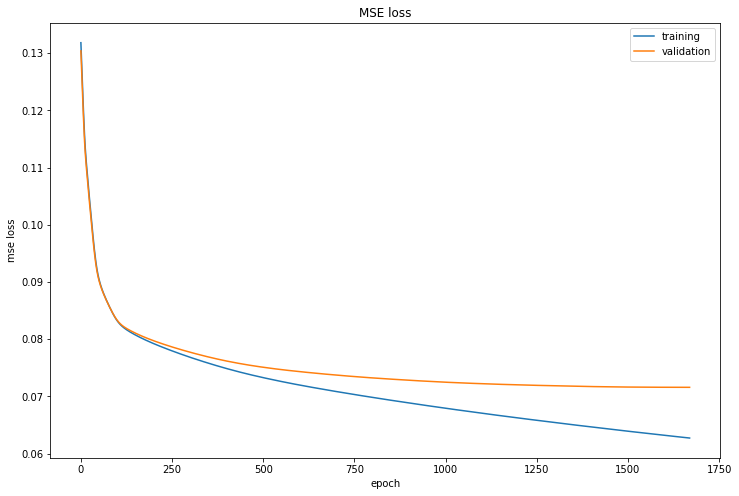

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [18]:
predictions = model.predict(test_input)

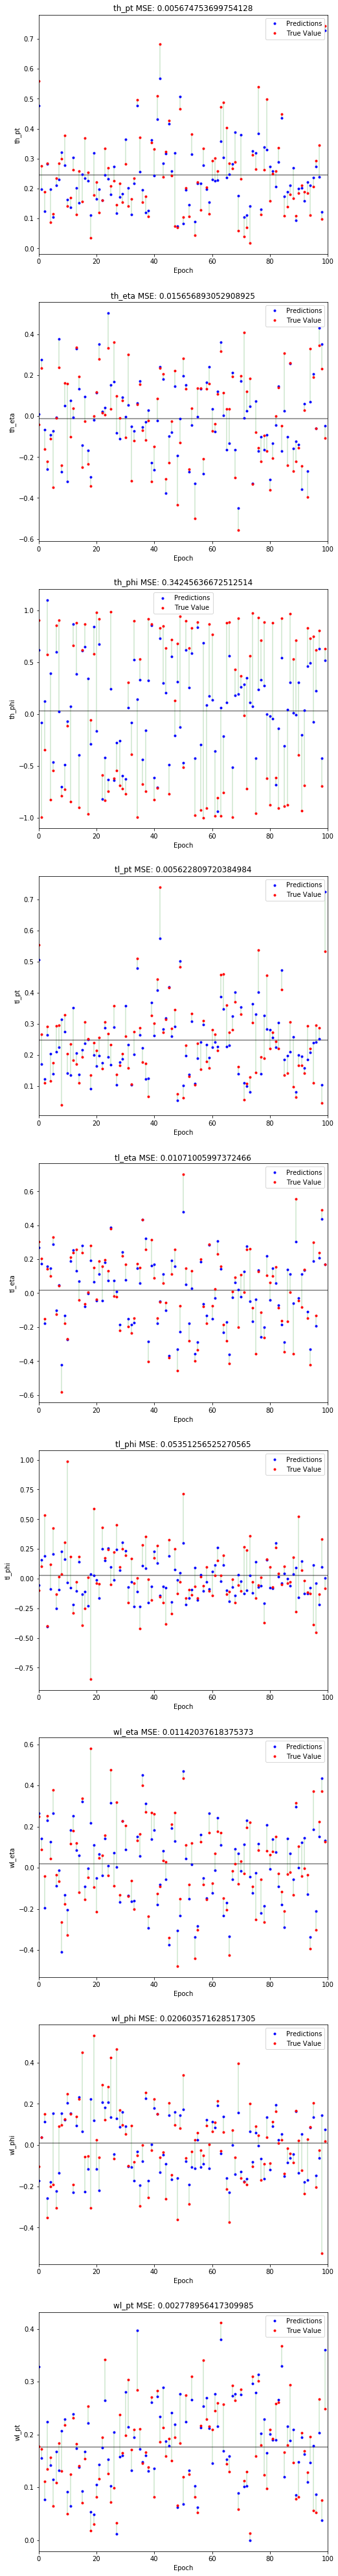

In [19]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [20]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.06648270411138278
th_pt MSE :  0.0068211654
th_eta MSE :  0.0205613396
th_phi MSE :  0.4251403045
tl_pt MSE :  0.0059706642
tl_eta MSE :  0.0153306874
tl_phi MSE :  0.0820078540
wl_eta MSE :  0.0099262038
wl_phi MSE :  0.0293730430
wl_pt MSE :  0.0032130751


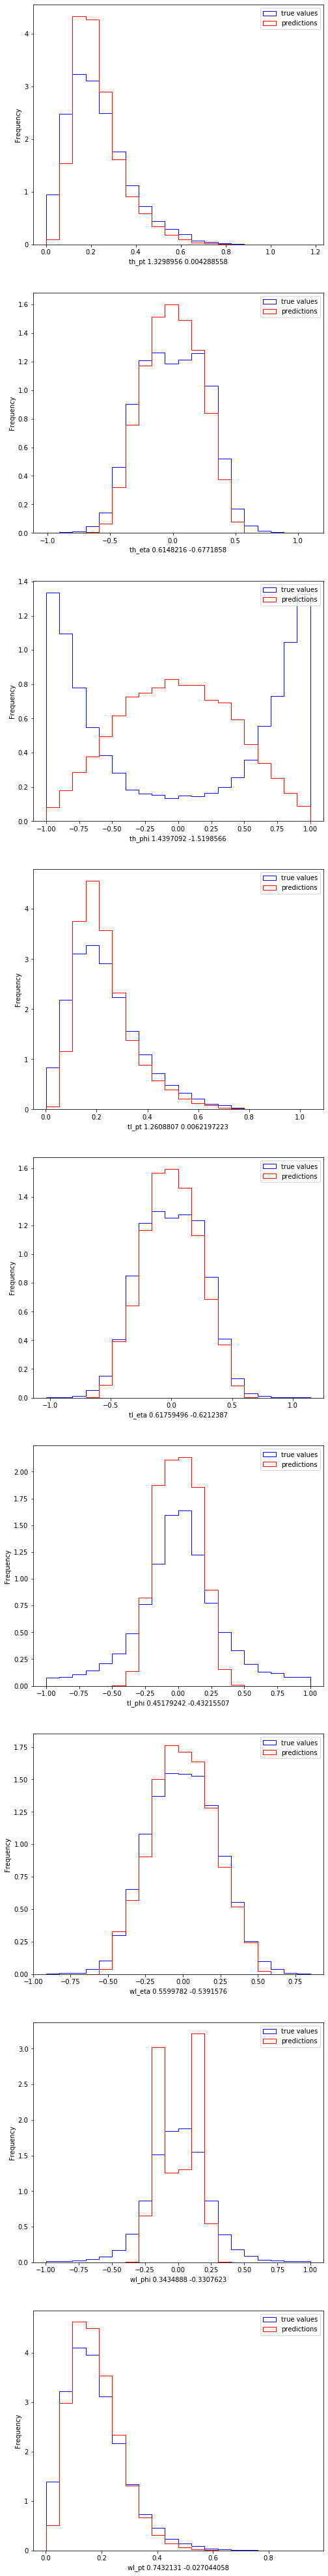

In [21]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [22]:
total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean)[split:,:]


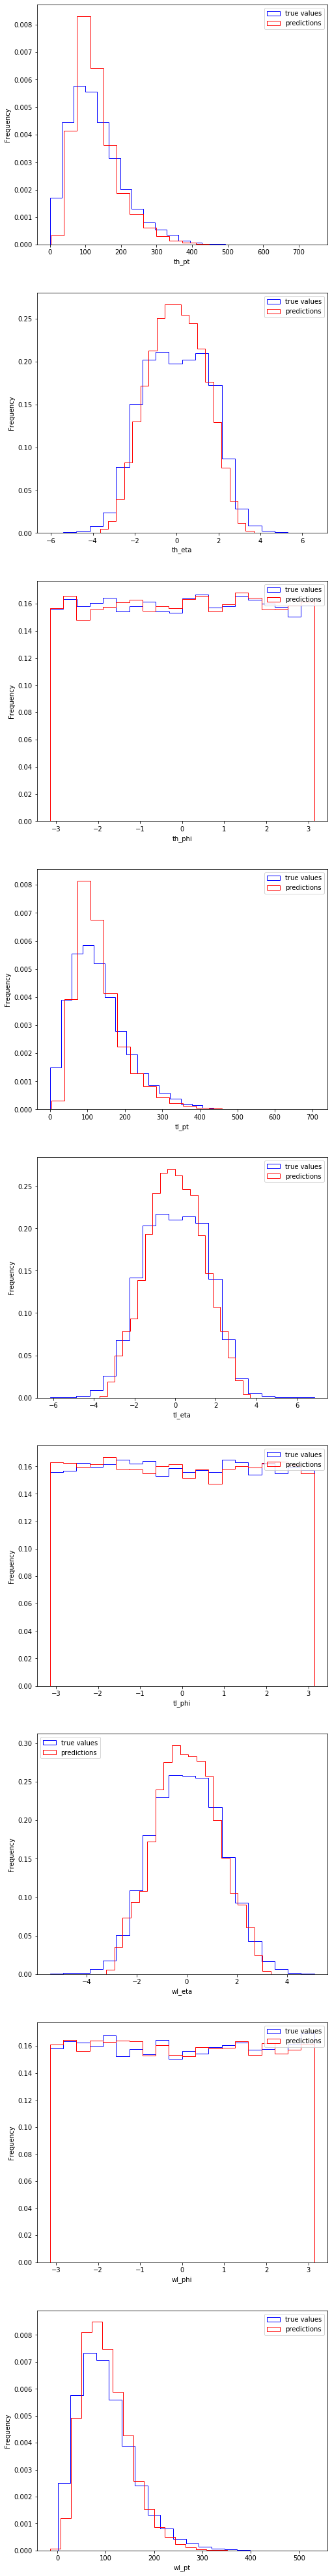

In [23]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [24]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  2132.6944765460
Original Scale th_eta MSE :  0.7363407456
Original Scale th_phi MSE :  2.9880660677
Original Scale tl_pt MSE :  1866.7781708907
Original Scale tl_eta MSE :  0.5490211238
Original Scale tl_phi MSE :  0.7902703490
Original Scale wl_eta MSE :  0.3554762694
Original Scale wl_phi MSE :  0.2821125726
Original Scale wl_pt MSE :  1004.5948319576


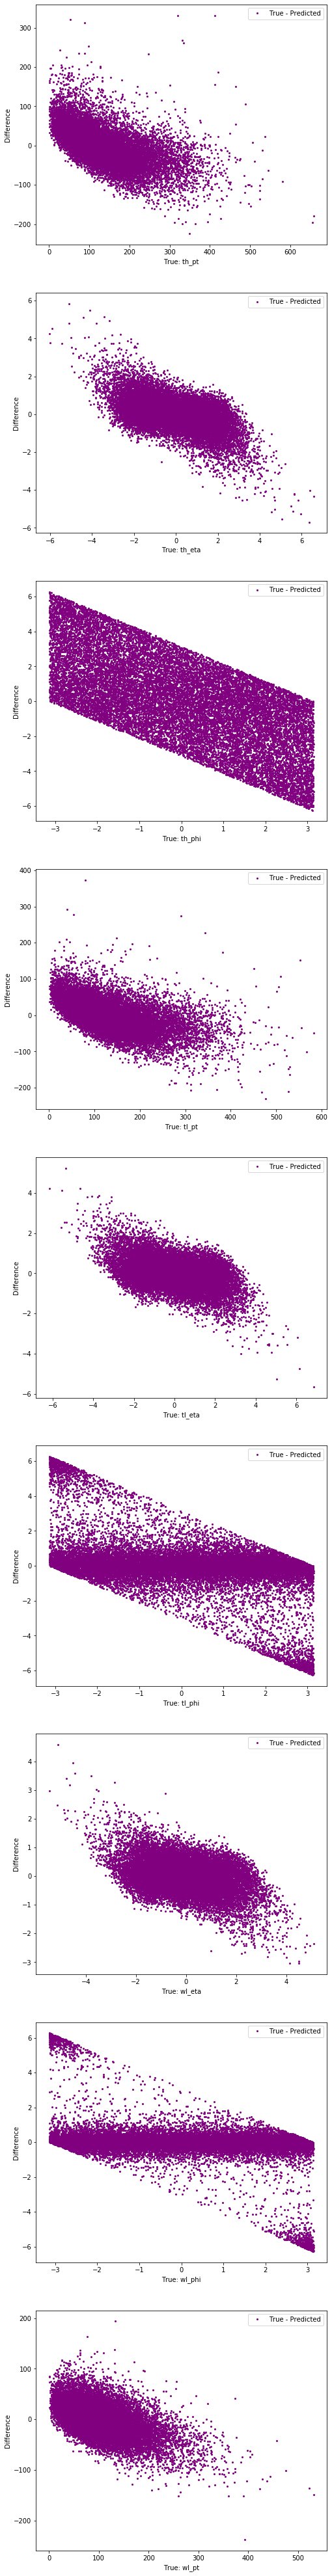

In [25]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')